## Отчет по анализу студентов для определения группы риска

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

# pd.set_option('display.max_rows', 50) # показывать больше строк
# pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [2]:
# Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:
display(students.head(10))
students.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,...,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,...,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,...,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,...,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,...,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

### Всего 395 строк и 30 колонок, из которых 17 объектного типа, остальные цифровые. В среднем имеют не много пустых ячеек, поэтому заполним их. Проинтерполируем предыдущие значения на пустые ячейки. 

In [3]:
for col in students.columns:
    students.loc[:, col] = students.loc[:, col].interpolate(method='pad')

### Пробежимся по всем столбцам, чтобы увидеть неверные значения и убрать их

In [4]:
def view(col):
    return print(col, '\n', students.loc[:, col].value_counts(), '\n')


for col in students.columns:
    view(col)

school 
 GP    349
MS     46
Name: school, dtype: int64 

sex 
 F    208
M    187
Name: sex, dtype: int64 

age 
 16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64 

address 
 U    304
R     91
Name: address, dtype: int64 

famsize 
 GT3    279
LE3    115
Name: famsize, dtype: int64 

Pstatus 
 T    353
A     42
Name: Pstatus, dtype: int64 

Medu 
 4.0    132
2.0    103
3.0     97
1.0     60
0.0      3
Name: Medu, dtype: int64 

Fedu 
 2.0     112
3.0     105
4.0      92
1.0      83
0.0       2
40.0      1
Name: Fedu, dtype: int64 

Mjob 
 other       138
services    105
at_home      63
teacher      57
health       32
Name: Mjob, dtype: int64 

Fjob 
 other       215
services    115
teacher      30
at_home      19
health       16
Name: Fjob, dtype: int64 

reason 
 course        146
reputation    108
home          105
other          36
Name: reason, dtype: int64 

guardian 
 mother    273
father     93
other      29
Name: guardian, 

### Первичный осмотр показал, что у нас есть неправильные значения в столбцах 'Fedu' = 40, 'famrel'=-1 (у кого-то очень умный отец, а у кого-то очень плохие отношения в семье). Заменим данные значения на 4.0 и 1 соотвественно.

In [5]:
students.Fedu = students.Fedu.astype(float).apply(
    lambda x: 4.0 if x == 40.0 else x)

students.famrel = students.famrel.astype(
    float).apply(lambda x: 1.0 if x == -1.0 else x)

In [6]:
print(students.loc[:, 'Fedu'].value_counts())

print(students.loc[:, 'famrel'].value_counts())

2.0    112
3.0    105
4.0     93
1.0     83
0.0      2
Name: Fedu, dtype: int64
4.0    192
5.0    110
3.0     68
2.0     17
1.0      8
Name: famrel, dtype: int64


### Рассмотрим главный столбец "score".

count    395.000000
mean      52.303797
std       22.962867
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

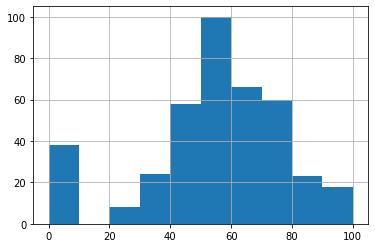

In [7]:
students.score.hist()
students.score.describe()

### Из графика видно, что большинство учеников сдали экзамены в диапазоне оценок от 40 до 80, но при этом часть учеников (около 40) по данным из таблицы получили за экзамен 0 баллов. Посмотрим на этих учеников:

In [8]:
students_0 = students[students.score == 0.0]
students_0

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,GT3,T,2.0,2.0,at_home,other,...,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,...,-9.0,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,T,1.0,1.0,at_home,other,...,-3.0,yes,yes,yes,4.0,2.0,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,...,-6.0,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,teacher,...,-9.0,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,...,-6.0,yes,no,no,4.0,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,4.0,other,other,...,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,...,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,...,-3.0,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,...,-6.0,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


### Далее было проведено сравнение данной таблицы и таблицы с полным списком участников. По многим параметрам ученики, не сдавшие экзамены, ничем не отличаются от тех кто сдавал, но были замечены отличия:

<AxesSubplot:>

<AxesSubplot:>

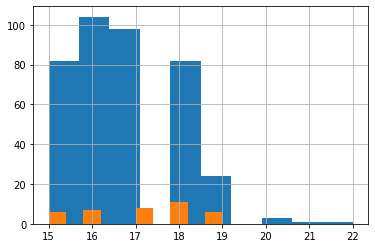

In [9]:
display(students['age'].hist())
display(students_0['age'].hist())

### Обычные ученики в своей массе сдают экзамен до 17 лет, при этом большинство несдающих 17-19 лет.

<AxesSubplot:>

<AxesSubplot:>

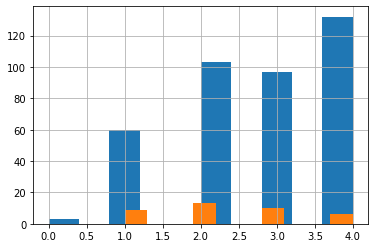

In [10]:
display(students['Medu'].hist())
display(students_0['Medu'].hist())

### Образование матерей "нулевых" студентов в целом ниже среднестатистического.

<AxesSubplot:>

<AxesSubplot:>

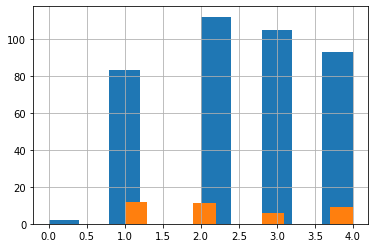

In [11]:
display(students['Fedu'].hist())
display(students_0['Fedu'].hist())

### Также дела обстоят с образованием отцов.

<AxesSubplot:>

<AxesSubplot:>

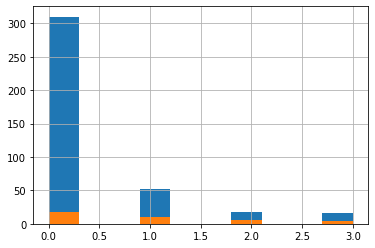

In [12]:
display(students['failures'].hist())
display(students_0['failures'].hist())

### Статистика показывает, что среди несдававших экзамен учеников, повышенный процент тех, кто уже до этого экзамен провалил. 

<AxesSubplot:>

<AxesSubplot:>

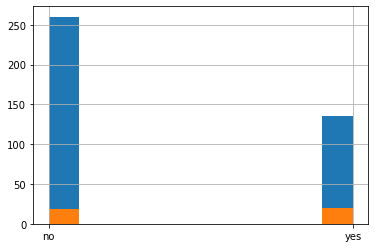

In [13]:
display(students['romantic'].hist())
display(students_0['romantic'].hist())

### Также  одной из особенностей является больший процент "нулевых" ребят в романтических отношениях.

<AxesSubplot:>

<AxesSubplot:>

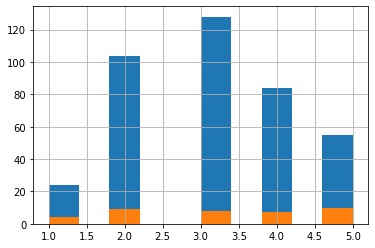

In [14]:
display(students['goout'].hist())
display(students_0['goout'].hist())

### И еще они гуляют чаще.

<AxesSubplot:>

<AxesSubplot:>

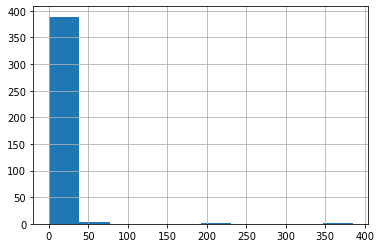

In [15]:
display(students['absences'].hist())
display(students_0['absences'].hist())

### А еще у них потрясающая статистика по прогулам! Практически никто не прогуливает. 

###  По проведенному анализу тех, кто не пришел на экзамен, можно сказать, что в группе риска могут оказаться те, чьи родители также плохо учились или имеют слабое образование. Также есть корреляция между отрицательным опытом (failures) и тем, что ученик не придет на экзамен. 

### Теперь постараемся учесть, только те параметры, которые имеют большее влияние на итоговую оценку:
### 1. Отбираю тех учеников, которые сдали экзамен.
### 2. Среднее значение, получаемое учеником, составляет 55.  Для объектного типа я выберу только те столбцы, в которых медиана оценки не равна 55, соответственно этот параметр будет корректировать финальную оценку.
### 3. Проведу корреляционный анализ числовых значений и учту их влияние на оценку.

<AxesSubplot:xlabel='school', ylabel='score'>

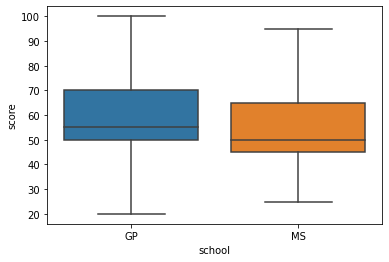

In [16]:
# Убираем "лишних" студентов
students = students[students.score > 0]

# Далее пример, того как выбирается объектный тип
sns.boxplot(x='school', y='score', data=students)

### Соответственно столбец "школа" остается, т.к. в зависимости от школы можно сдать экзамен хуже на 5 баллов

In [17]:
students[students.school == 'MS'].score.median()

50.0

In [18]:
# Воспользуемся функцией Counter
from collections import Counter

# выделим только объектный тип данных в таблицу и добавим к нему столбец score
students_object = students.select_dtypes(include=['object'])

students_object = students_object.merge(
    students['score'], left_index=True, right_index=True)

# пройдем все столбцы и выберим из них те, у кого медиана не равна 55
for col in students_object.columns[:-1]:
    keys = Counter(students_object[col]).keys()
    print('\n', col)
    for x in keys:
        y = students_object[students_object[col] == x].score.median()
        print(x, '=', y)


 school
GP = 55.0
MS = 50.0

 sex
F = 55.0
M = 60.0

 address
U = 55.0
R = 55.0

 famsize
nan = nan
GT3 = 55.0
LE3 = 55.0

 Pstatus
A = 55.0
T = 55.0

 Mjob
at_home = 50.0
health = 65.0
other = 55.0
services = 55.0
teacher = 55.0

 Fjob
teacher = 70.0
other = 55.0
health = 55.0
services = 55.0
at_home = 60.0

 reason
course = 55.0
other = 55.0
home = 55.0
reputation = 60.0

 guardian
mother = 55.0
father = 55.0
other = 55.0

 schoolsup
yes = 50.0
no = 60.0

 famsup
no = 55.0
yes = 55.0

 paid
no = 55.0
yes = 55.0

 activities
no = 55.0
yes = 55.0

 nursery
yes = 55.0
no = 55.0

 higher
yes = 55.0
no = 50.0

 internet
nan = nan
yes = 55.0
no = 55.0

 romantic
no = 55.0
yes = 55.0


### Очень интересная статистика по школьной поддержке, если она есть, то результаты будут хуже примерно на 20% :)

### Уберем столбцы: address, famsize, Pstatus, guardian, famsup, paid,  activities, nursery, internet, romantic, т.к. медиана каждого значения в столбце равна 55 и предполагаем, что этот параметр не влияет на итоговую оценку.

In [19]:
columns = ['address', 'famsize', 'Pstatus', 'guardian',
           'famsup', 'paid', 'activities', 'nursery', 'internet', 'romantic']
students.drop(columns, inplace=True, axis=1)

### Теперь проверям корреляцию числовых значений исходных данных

In [20]:
students.corr().score

age                   -0.125832
Medu                   0.170837
Fedu                   0.118079
traveltime            -0.070027
studytime              0.137723
failures              -0.257974
studytime, granular   -0.137723
famrel                 0.052255
freetime              -0.009255
goout                 -0.184183
health                -0.063099
absences              -0.014464
score                  1.000000
Name: score, dtype: float64

### Как видно из полученных данных, лучше всего коррелирует с итоговой оценкой значения предыдущих неудач, количетво времени проведенных с друзьями, образование родителей и дополнительное обучение. Похожие выводы были и для "нулевых" студентов.
### Время в пути до школы, свободное время, семейные отношения, здоровье ученика и его прогулы не влияют на итоговую оценку.

In [21]:
columns = ['traveltime', 'studytime, granular',
           'famrel', 'freetime', 'health', 'absences']
students.drop(columns, inplace=True, axis=1)

In [24]:
# Финальная таблица
students

,school,sex,age,Medu,Fedu,Mjob,Fjob,reason,studytime,failures,schoolsup,higher,goout,score
0,GP,F,18,4.0,4.0,at_home,teacher,course,2.0,0.0,yes,yes,4.0,30.0
1,GP,F,17,1.0,1.0,at_home,other,course,2.0,0.0,no,yes,3.0,30.0
2,GP,F,15,1.0,1.0,at_home,other,other,2.0,3.0,yes,yes,2.0,50.0
3,GP,F,15,4.0,2.0,health,other,home,3.0,0.0,no,yes,2.0,75.0
4,GP,F,16,3.0,3.0,other,other,home,2.0,0.0,no,yes,2.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,2.0,2.0,services,services,course,2.0,2.0,no,yes,4.0,45.0
391,MS,M,17,3.0,1.0,services,services,course,1.0,0.0,no,yes,5.0,80.0
392,MS,M,21,1.0,1.0,other,other,course,1.0,3.0,no,yes,3.0,35.0
393,MS,M,18,3.0,2.0,services,other,course,1.0,0.0,no,yes,1.0,50.0


## По результатам анализа всей таблицу мы получили следующие выводы:
### 1. Плохо сдадут экзамен или не придут на него те, кто до этого уже его проваливал.
### 2. Важную роль в результатах экзамена играют родители и их образование. При этом если отец учитель, или мать доктор, шансы сдать хорошо экзамен очень велики.
### 3. Проведение времени с друзьями также будет негативно оказывать влияние на экзамен.

In [22]:
# Дополнительно хотелось бы посмотреть на самых лучших студентов
students[students.score > 90]

,school,sex,age,Medu,Fedu,Mjob,Fjob,reason,studytime,failures,schoolsup,higher,goout,score
8,GP,M,15,3.0,2.0,services,other,home,2.0,0.0,no,yes,2.0,95.0
47,GP,M,16,4.0,3.0,health,services,reputation,4.0,0.0,no,yes,2.0,100.0
110,GP,M,15,4.0,4.0,teacher,teacher,course,1.0,0.0,no,yes,3.0,95.0
113,GP,M,15,4.0,2.0,teacher,other,course,1.0,0.0,no,yes,2.0,95.0
286,GP,F,18,2.0,1.0,at_home,at_home,other,3.0,0.0,no,yes,3.0,95.0
374,MS,F,18,4.0,2.0,other,at_home,reputation,3.0,0.0,no,yes,4.0,95.0


### Как видно из таблицы, не смотря на все выводы отчета, сдать экзамен на отлично можно, даже если родители без образования.  Надо стремиться поступить в ВУЗ и тратить время на учебу по мимо школы.

## Прохождение данного модуля было интересным и познавательным, особенно изучение материалов с видеозаписями. К сожалению, не успел углубиться в данную тему. По-хорошему надо проводить тщательный анализ каждого столбца, смотреть его в комплексе с другими данными. 
## В данном отчете выделил только те столбцы, которые по подсчетам оказывают наибольшее влияние на оценку студентов, но в финале надо получить мат. модель, в которую надо вводить данные ученика и получать прогноз его оценки. Для меня это бы заняло еще сутки-двое, которых нет.